In [138]:
import pandas as pd
import numpy as np
import plotly.express as px
from pyproj import Proj
from datetime import datetime
import json
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, matthews_corrcoef, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
import time
import sqlalchemy
from sklearn.manifold import TSNE
import seaborn as sns
import missingno
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

##  Relevant Functions

In [27]:
def plot_cm(y_true, y_pred, out_path=None, out_name=None, figsize=7):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    labels=list(set(y_true).union(set(y_pred)))
    ax = sns.heatmap(cm, annot=True, fmt='g', xticklabels=labels, yticklabels=labels)
    ax.set(ylabel='True Values', xlabel='Predicted Values')
    ax.set_yticklabels(rotation=0, labels=labels)
    if out_path:
        plt.savefig(os.path.join(out_path, out_name))
        
def create_scans_df(wifi_df):
    wifi_df_new = wifi_df.reset_index(drop=True)
    scans_df = pd.DataFrame.from_records(list(wifi_df_new['rssi_by_bssid'])).join(wifi_df_new[['room_id', 'imei', 'timestamp']])
    scans_df['n_scans'] = scans_df.apply(lambda x: x.count()-2, axis=1)  # (-2) for columns 'room_id' and 'imei' in scans_df
    return scans_df

def preproccess(wifi_df, starting_date, keep_corridors=False):
    wifi_df = wifi_df.copy()
    wifi_df = wifi_df[wifi_df.timestamp > starting_date]
    wifi_df.drop(['roomId'],axis=1,inplace=True)
    wifi_df = wifi_df[wifi_df['rssi_by_bssid'] !={}]
    if not keep_corridors:
        wifi_df = wifi_df.dropna(subset=['room_id'])
    else:
        wifi_df['room_id'].fillna(0, inplace=True)
        wifi_df['room_id'] = wifi_df['room_id'].astype(int)

    #drop bad samples in room 42 of imei 87888aecf8b37f14  
    wifi_df = wifi_df[~((wifi_df['room_id'] == 42) & (wifi_df['imei'] == '87888aecf8b37f14'))]
    return wifi_df

def read_folder_to_wifi_df(folder):
    files = os.listdir(folder)
    dfs = []
    for file in files:
        txt = open(os.path.join(folder, file),"r", encoding="utf-8").read()
        txt = txt.replace("}{", "}, {")
        data = txt.split(', ')
        j=[]
        for d in data:
            if(len(d)>0):
                j.append(json.loads(d))
        df = pd.DataFrame(j)
        dfs.append(df)
    return pd.concat(dfs)

### Parameters

In [126]:
fields_to_drop = ['imei', 'room_id', 'timestamp']
fillna_rssi = -200
corridor = 0

In [127]:
# Fields to Drop
[column for column in scans_df.columns if ':' not in column]

['room_id', 'imei', 'timestamp', 'n_scans']

In [108]:
date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
path = date_time + '_output_folder'
os.mkdir(path) #new output folder in main dir

## Reading the log files

##### make sure that the folder contains only log files

In [3]:
rssi_folder_path = r'C:\Users\tal\Desktop\tamar\HospiTrack-master\Datasets\Friday'
wifi_df_orig = read_folder_to_wifi_df(rssi_folder_path)
th  = int(datetime.timestamp(datetime(2020, 4, 3, 9, 0, 0)))*1000

In [9]:
wifi_df = preproccess(wifi_df_orig, th)

In [11]:
print("Rooms for prediction : " + str(wifi_df.room_id.unique()))
print("Phones imeis : ")
imeis = list(wifi_df.imei.unique())
print(imeis)

Rooms for prediction : [31. 32. 33. 34. 35. 36. 41. 42. 43. 44. 45. 46.]
Phones imeis : 
['03ae308bd7102024', '2c0522a1c69b22bc', '87888aecf8b37f14', 'd2e242e0a080f7e7', 'ef3f50e69df5ed94']


### Create scans dataframe

In [28]:
scans_df = create_scans_df(wifi_df)
print(scans_df.shape)
scans_df.head(2)

(8906, 201)


40:9b:cd:ca:f1:7c  14:ae:db:36:68:6d  00:68:eb:17:2d:35  04:f0:21:41:db:76  \
0              -52.0              -59.0              -61.0              -78.0   
1              -53.0              -57.0              -54.0              -78.0   

   14:ae:db:54:2c:f5  40:9b:cd:ca:56:68  10:be:f5:3c:29:f6  b4:ee:b4:fe:21:fb  \
0              -81.0              -87.0              -88.0              -90.0   
1              -82.0              -85.0              -86.0                NaN   

   ec:9a:74:98:3c:9d  00:b8:c2:50:4f:21  ...  8c:59:c3:bb:95:5c  \
0              -91.0              -92.0  ...                NaN   
1              -88.0              -92.0  ...                NaN   

   a0:ab:1b:55:55:ee  12:13:31:c7:df:e3  10:5a:f7:1e:95:50  c4:12:f5:fd:ee:7c  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   

   60:e3:27:e8:3e:88  room_id              imei      timestamp  n_scans  
0                NaN     31.0  03ae308bd7102024  1585910576850       18  
1                NaN     31.0  03ae308bd7102024  1585910579913       14  

[2 rows x 201 columns]

## Room prediction for each phone separately

In [21]:
scans_df['imei'].unique()

array(['03ae308bd7102024', '2c0522a1c69b22bc', '87888aecf8b37f14',
       'd2e242e0a080f7e7', 'ef3f50e69df5ed94'], dtype=object)

In [134]:
parameters = {'n_estimators': [50,100,200],
             'max_depth': [5,10,15],
             'criterion': ['gini', 'entropy'],
             'max_features': [10]} #[int(np.log2(X_train.shape[1])), int(np.sqrt(X_train.shape[1]))]

rf_cv = GridSearchCV(RandomForestClassifier(random_state=1), 
                   parameters, 
                   n_jobs = -1,
                   cv = 4,
                   refit = True)

kf = KFold(n_splits=4)
#                    scoring = 'f1')

In [23]:
models = {}

In [29]:
scans_df.columns

Index(['40:9b:cd:ca:f1:7c', '14:ae:db:36:68:6d', '00:68:eb:17:2d:35',
       '04:f0:21:41:db:76', '14:ae:db:54:2c:f5', '40:9b:cd:ca:56:68',
       '10:be:f5:3c:29:f6', 'b4:ee:b4:fe:21:fb', 'ec:9a:74:98:3c:9d',
       '00:b8:c2:50:4f:21',
       ...
       '8c:59:c3:bb:95:5c', 'a0:ab:1b:55:55:ee', '12:13:31:c7:df:e3',
       '10:5a:f7:1e:95:50', 'c4:12:f5:fd:ee:7c', '60:e3:27:e8:3e:88',
       'room_id', 'imei', 'timestamp', 'n_scans'],
      dtype='object', length=201)

In [135]:
#results list
results = []
grid_search = True
nan_fill_value = -200

for imei in imeis:
    start = time.time()
    #train test split by imei:
    train = scans_df[scans_df['imei']!=imei]
    test = scans_df[scans_df['imei']==imei]

    X_train = train.drop(columns=fields_to_drop).fillna(fillna_rssi)
    X_test = test.drop(columns=fields_to_drop).fillna(fillna_rssi)
    y_train = train['room_id']
    y_test = test['room_id']
    
    if not grid_search:
        rf = RandomForestClassifier()
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
    
    if grid_search:
        rf_cv.fit(X_train, y_train)
        rf_best_model = rf_cv.best_estimator_
        y_pred = rf_best_model.predict(X_test)
    
    #add the result to list
    models[imei] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train,'y_test':y_test, 'y_pred':y_pred, 'model':rf_best_model}
    results.append([y_test, y_pred])
    print(time.time()-start)


36.287333250045776
36.86524295806885
39.04083180427551
37.05252242088318
36.09926891326904


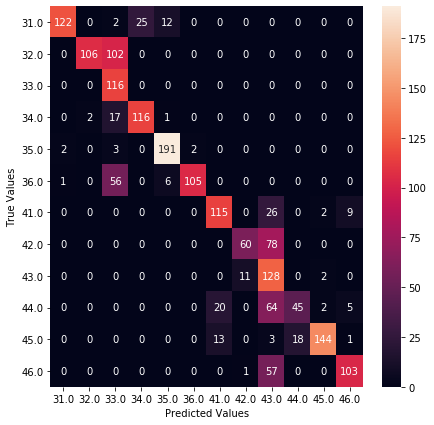

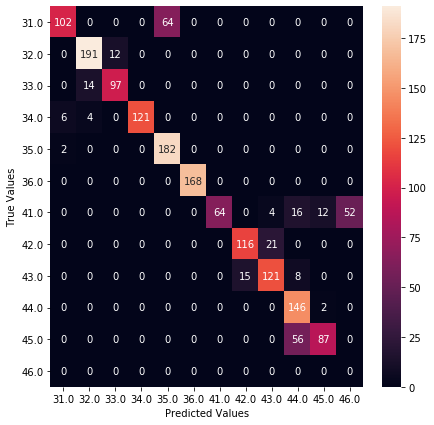

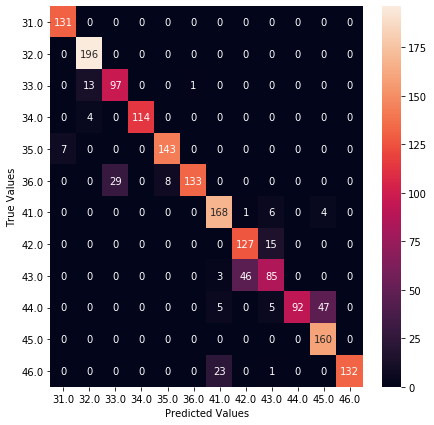

In [131]:
for y_true, y_pred in results:
    plot_cm(y_true, y_pred)

In [130]:
# No grid search, With N_SCANS
date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
for i in range(len(imeis)):
    print(f"f1 Score of {imeis[i]} : " + str(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))+"\n")

f1 Score of 03ae308bd7102024 : 0.7119811672153561

f1 Score of 2c0522a1c69b22bc : 0.7627294644468338

f1 Score of 87888aecf8b37f14 : 0.8285230666037297

f1 Score of d2e242e0a080f7e7 : 0.8737776784884569

f1 Score of ef3f50e69df5ed94 : 0.8690220710778771



In [136]:
# With grid search, With N_SCANS
date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
for i in range(len(imeis)):
    print(f"f1 Score of {imeis[i]} : " + str(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))+"\n")

f1 Score of 03ae308bd7102024 : 0.723149352017617

f1 Score of 2c0522a1c69b22bc : 0.7543363257728273

f1 Score of 87888aecf8b37f14 : 0.8350875540619392

f1 Score of d2e242e0a080f7e7 : 0.8720647671112495

f1 Score of ef3f50e69df5ed94 : 0.8769894239402932



In [98]:
#write the results to log file in output dir

date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
# f = open(path + "\\" + date_time + '_results.txt','w')
for i in range(len(imeis)):
#     f.write(f"Prediction results for phone : {imeis[i]} \n\n")
#     f.write(classification_report(results[i][0],results[i][1]))
#     f.write(f" \n Confusion matrix : \n")
#     f.write(str(confusion_matrix(results[i][0],results[i][1]))+"\n\n")
#     f.write("Accuracy Score : " + str(accuracy_score(results[i][0],results[i][1]))+"\n")
#     f.write("f1 Score : " + str(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))+"\n")
#     f.write("MCC Score : " + str(matthews_corrcoef(results[i][0],results[i][1]))+"\n")
#     f.write("\n______________________________________________________\n\n")
    print(f"f1 Score of {imeis[i]} : " + str(f1_score(results[i][0],results[i][1],pos_label='positive',average='macro'))+"\n")
# f.close()

f1 Score of 03ae308bd7102024 : 0.7117036816807603

f1 Score of 2c0522a1c69b22bc : 0.7518469606961641

f1 Score of 87888aecf8b37f14 : 0.8361858187838327

f1 Score of d2e242e0a080f7e7 : 0.8757805350559918

f1 Score of ef3f50e69df5ed94 : 0.874533933096751



##  T_SNE Checks

In [99]:
X = scans_df.drop(columns = fields_to_drop).fillna(fillna_rssi)
y = scans_df['room_id']
X_tsne = TSNE(n_components=2).fit_transform(X)

In [100]:
aparts = y.apply(lambda x:str(x)[0])

In [110]:
tsne_df = pd.DataFrame(X_tsne).rename(columns={0:'first', 1:'second'})
tsne_df['apart'] = aparts
tsne_df['room_id'] = y
tsne_df['imei'] = scans_df['imei']

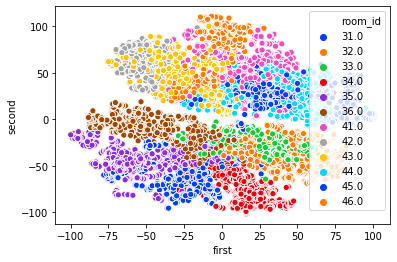

In [150]:
sns.scatterplot(x=tsne_df['first'], y=tsne_df['second'], hue=y, palette='bright')

In [109]:
plt.figure(figsize=(45, 45))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

plt.subplot(2,2,1)
tsne_apart = tsne_df[tsne_df['apart'] == '3']
sns.scatterplot(x=tsne_apart['second'], y=tsne_apart['first'], hue=tsne_apart['room_id'], palette='bright')
plt.title('T_SNE- Dimensionality Reduction \n Routers data only \n Apartmant No 1')

plt.subplot(2,2,2)
tsne_apart = tsne_df[tsne_df['apart'] == '4']
sns.scatterplot(x=tsne_apart['second'], y=tsne_apart['first'], hue=tsne_apart['room_id'], palette='bright')
plt.title('T_SNE- Dimensionality Reduction \n Routers data only \n Apartmant No 2')

Text(0.5, 1.0, 'T_SNE- Dimensionality Reduction \n Routers data only \n Apartmant No 2')

In [117]:
#results list
t_sne_models = {}
t_sne_results = []

nan_fill_value = -200

for imei in imeis:
    start = time.time()
    #train test split by imei:
    train = tsne_df[tsne_df['imei']!=imei]
    test = tsne_df[tsne_df['imei']==imei]

    X_train = train[['second', 'first']].fillna(fillna_rssi)
    X_test = test[['second', 'first']].fillna(fillna_rssi)
    y_train = train['room_id']
    y_test = test['room_id']
    
    rf_cv.fit(X_train, y_train)
    rf_best_model = rf_cv.best_estimator_
    y_pred = rf_best_model.predict(X_test)
    
    #add the result to list
    t_sne_models[imei] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train,'y_test':y_test, 'y_pred':y_pred, 'model':rf_best_model}
    t_sne_results.append([y_test, y_pred])
    print(time.time()-start)


62.99442648887634
75.16096425056458
76.14988899230957
76.76459002494812
73.50352597236633


In [119]:
for result in t_sne_results:
    print('fi score', f1_score(result[0],result[1],pos_label='positive',average='macro'))

fi score 0.4816302035237218
fi score 0.6356681278945939
fi score 0.5670508133666962
fi score 0.6975924145674396
fi score 0.6931446774265422


##  PCA Checks

In [120]:
X = scans_df.drop(columns = fields_to_drop).fillna(fillna_rssi)
y = scans_df['room_id']
aparts = y.apply(lambda x:str(x)[0])

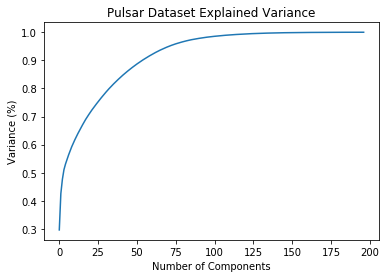

In [121]:
#Plotting the Cumulative Summation of the Explained Variance
pca = PCA().fit(X)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()

In [122]:
pca = PCA(n_components=100).fit(X)

In [123]:
x_pca =pca.transform(X)

pca_df = pd.DataFrame(x_pca)
pca_df['apart'] = aparts
pca_df['room_id'] = y
pca_df['imei'] = scans_df['imei']

In [124]:
#results list
pca_models = {}
pca_results = []

nan_fill_value = -200

for imei in imeis:
    start = time.time()
    #train test split by imei:
    train = pca_df[pca_df['imei']!=imei]
    test = pca_df[pca_df['imei']==imei]
    
    X_train = train.drop(columns=['apart', 'room_id', 'imei']).fillna(fillna_rssi)
    X_test = test.drop(columns=['apart', 'room_id', 'imei']).fillna(fillna_rssi)
    y_train = train['room_id']
    y_test = test['room_id']
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    #add the result to list
    pca_models[imei] = {'X_train':X_train, 'X_test':X_test, 'y_train':y_train,'y_test':y_test, 'y_pred':y_pred, 'model':rf_best_model}
    pca_results.append([y_test, y_pred])
    print(time.time()-start)


7.235243558883667
8.646535158157349
9.334283828735352
7.960007190704346
7.6199469566345215


In [125]:
for result in pca_results:
    print('fi score', f1_score(result[0],result[1],pos_label='positive',average='macro'))

fi score 0.6533808989046889
fi score 0.6643791285237555
fi score 0.6871909520760386
fi score 0.6763267842637002
fi score 0.7968861117679403


In [453]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X)
X_pca =pca.transform(X)
aparts = y.apply(lambda x:str(x)[0])

pca_df = pd.DataFrame(X_pca).rename(columns={0:'first', 1:'second'})
pca_df['apart'] = aparts
pca_df['room_id'] = y

Text(0.5, 1.0, 'PCA- Dimensionality Reduction \n Routers data only')

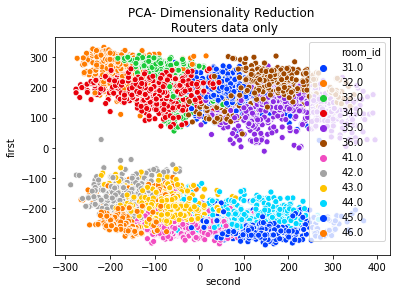

In [56]:
#PCA without timestamps
sns.scatterplot(x=pca_df['second'], y=pca_df['first'], hue=pca_df['room_id'], palette='bright')
plt.title('PCA- Dimensionality Reduction \n Routers data only')

Text(0.5, 1.0, 'PCA- Dimensionality Reduction \n Routers data only')

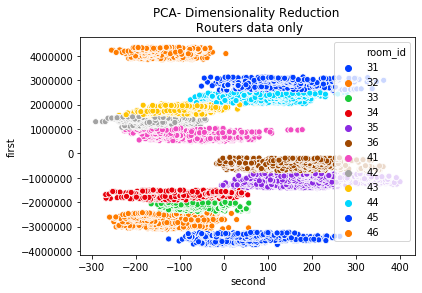

In [365]:
#PCA with timestamps
sns.scatterplot(x=pca_df['second'], y=pca_df['first'], hue=pca_df['room_id'], palette='bright')
plt.title('PCA- Dimensionality Reduction \n Routers data only')

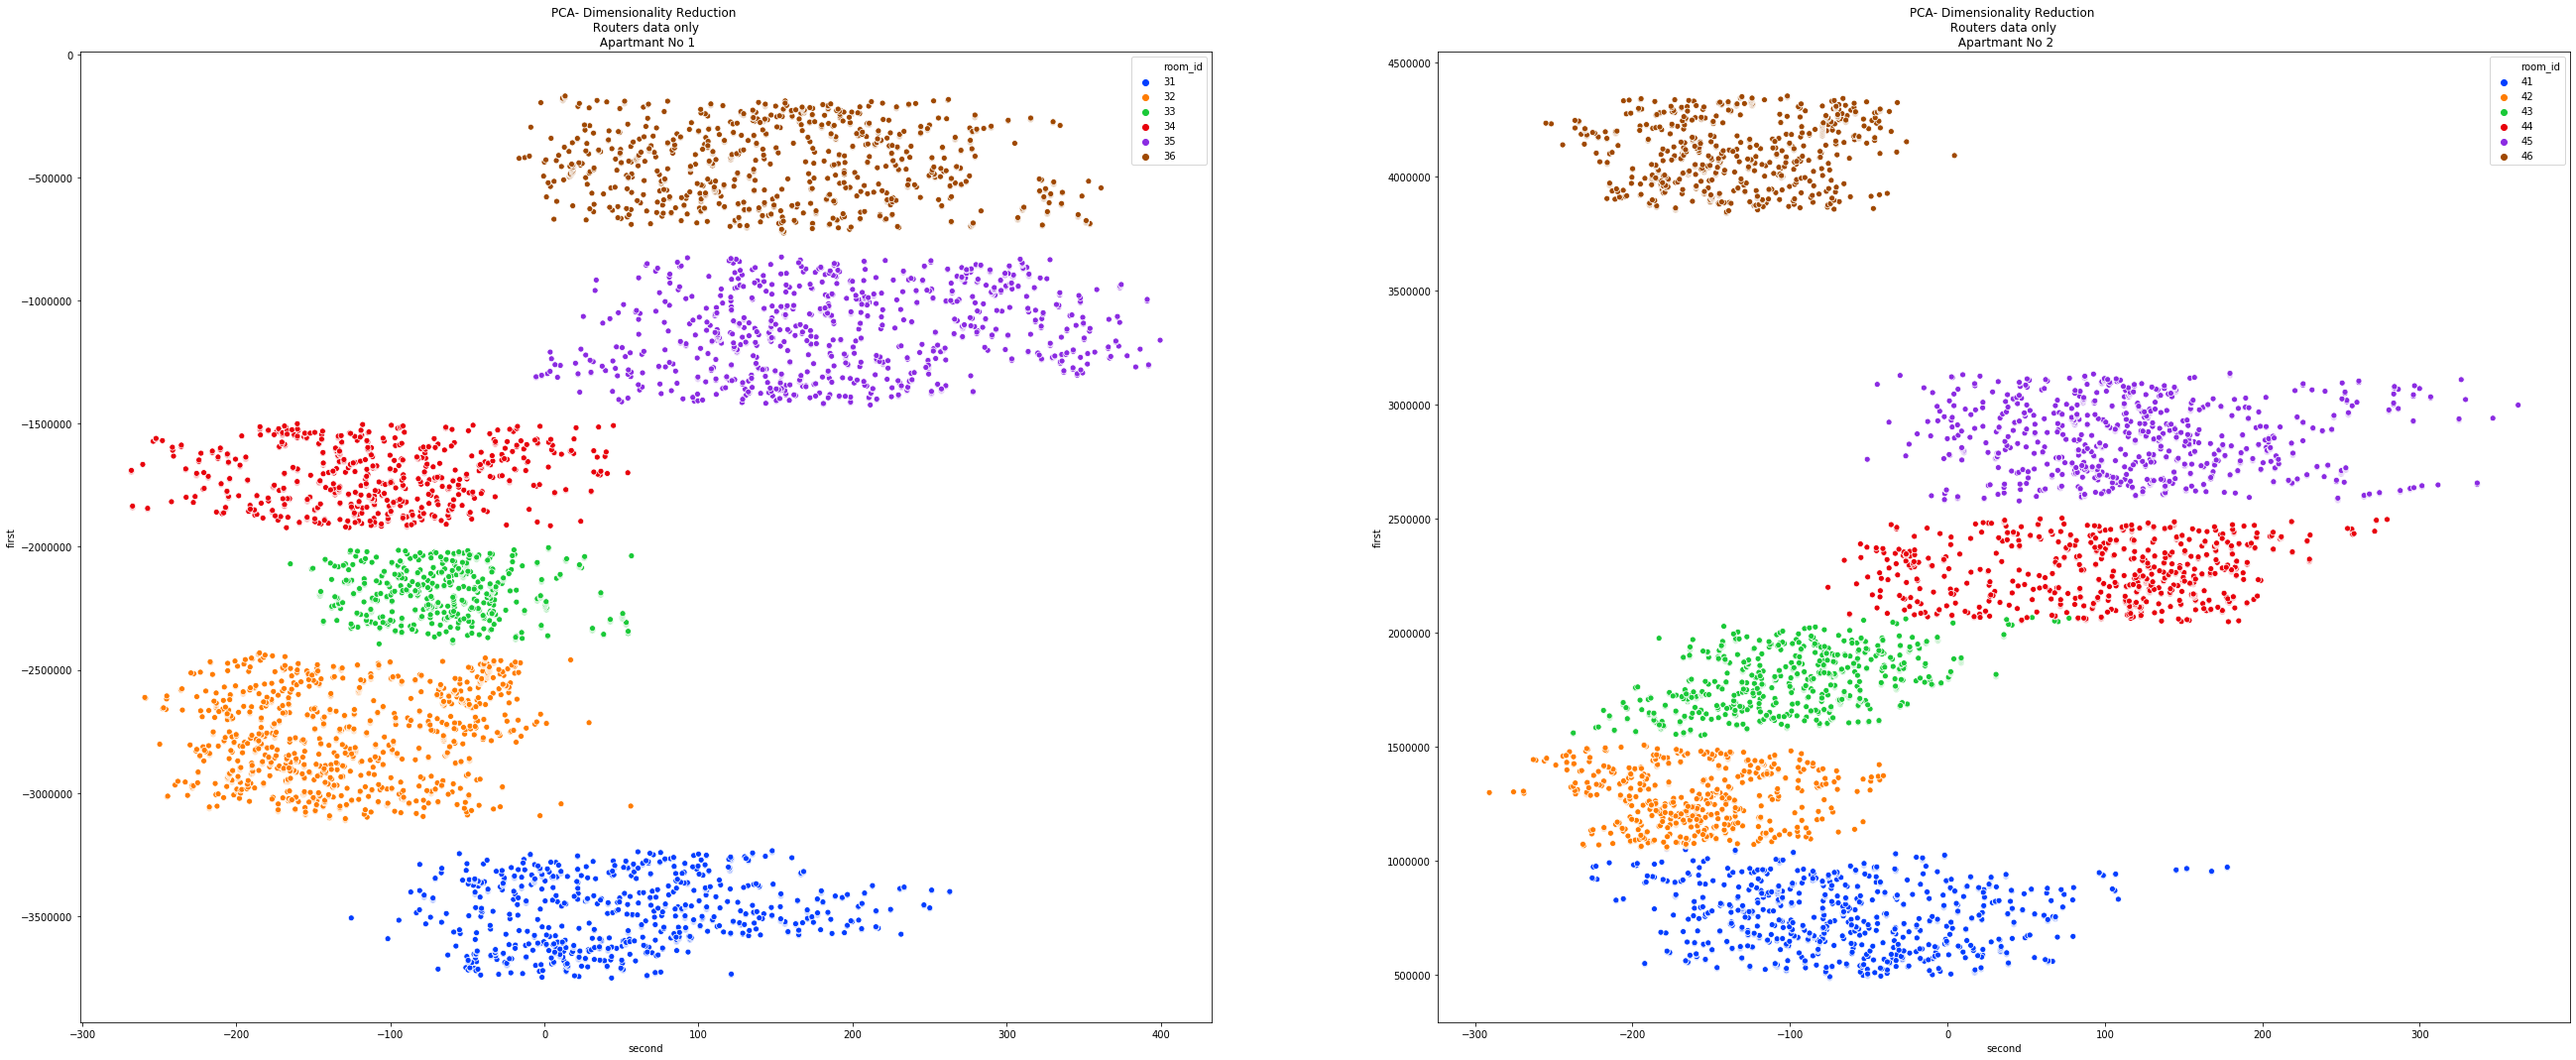

In [369]:
plt.figure(figsize=(45, 45))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

plt.subplot(2,2,1)
plt.title('PCA- Dimensionality Reduction \n Routers data only \n Apartmant No 1')
pca_apart = pca_df[pca_df['apart'] == '3']
sns.scatterplot(x=pca_apart['second'], y=pca_apart['first'], hue=pca_apart['room_id'], palette='bright')

plt.subplot(2,2,2)
plt.title('PCA- Dimensionality Reduction \n Routers data only \n Apartmant No 2')
pca_apart = pca_df[pca_df['apart'] == '4']
sns.scatterplot(x=pca_apart['second'], y=pca_apart['first'], hue=pca_apart['room_id'], palette='bright')


In [377]:
from sklearn.cluster import KMeans

In [378]:
km = KMeans(n_clusters=6)
km.fit(pca_apart[['second', 'first']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

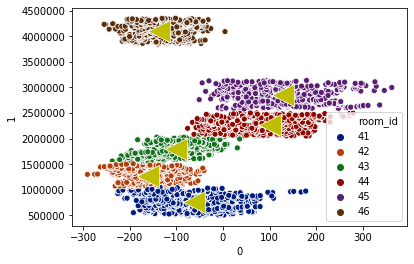

In [402]:
sns.scatterplot(x=pca_apart['second'], y=pca_apart['first'], hue=pca_apart['room_id'], palette='dark')
sns.scatterplot(x=pd.DataFrame(km.cluster_centers_)[0], y=pd.DataFrame(km.cluster_centers_)[1], color='y', s=500, marker='<')

In [410]:
out_clusters = pd.DataFrame({'y_pred':km.labels_, 'y_true':pca_apart['room_id']})

In [409]:
replace = {0:45, 1:42, 2:44, 3:46, 4:41, 5:43}

out_clusters.y_pred.replace(replace, inplace=True)

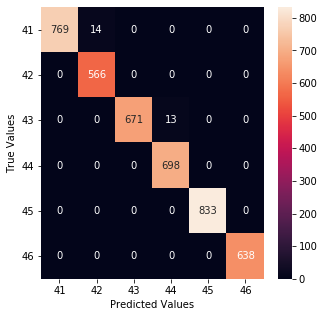

In [417]:
plot_cm(out_clusters['y_true'], out_clusters['y_pred'], figsize=5)

##  Check Unsupervised

In [146]:
X = scans_df.drop(fields_to_drop, axis=1).fillna(fillna_rssi)
y = scans_df['room_id']

In [147]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [160]:
dbs_runs = pd.DataFrame(X_scaled.copy())

In [148]:
pca = PCA(n_components=2).fit(X_scaled)
X_pca =pca.transform(X_scaled)
aparts = y.apply(lambda x:str(x)[0])

pca_df = pd.DataFrame(X_pca).rename(columns={0:'first', 1:'second'})
pca_df['apart'] = aparts
pca_df['room_id'] = y

Text(0.5, 1.0, 'PCA- Dimensionality Reduction \n Routers data only')

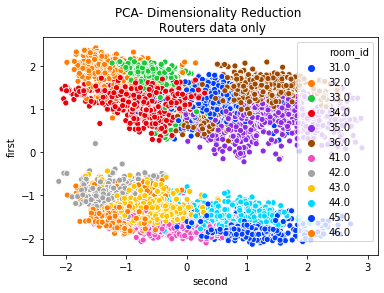

In [149]:
sns.scatterplot(x=pca_df['second'], y=pca_df['first'], hue=pca_df['room_id'], palette='bright')
plt.title('PCA- Dimensionality Reduction \n Routers data only')

In [151]:
dbs = DBSCAN().fit(X_scaled)

In [162]:
dbs_runs['run_1'] = dbs.labels_

In [163]:
dbs = DBSCAN(min_samples=3).fit(X_scaled)

In [164]:
dbs_runs['run_2'] = dbs.labels_

Text(0.5, 1.0, 'PCA- Dimensionality Reduction \n Routers data only')

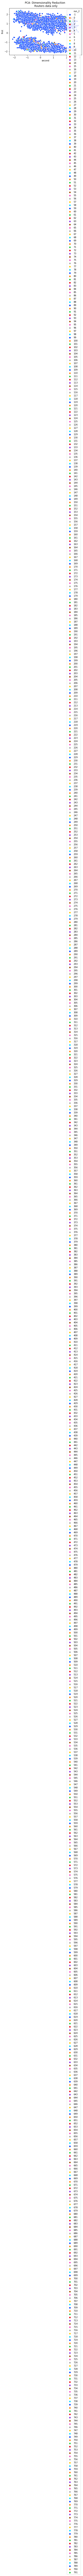

In [166]:
sns.scatterplot(x=pca_df['second'], y=pca_df['first'], hue=dbs_runs['run_2'], palette='bright')
plt.title('PCA- Dimensionality Reduction \n Routers data only')

##  New Data Check

In [92]:
new_folder_path = r'C:\Users\tal\Desktop\tamar\HospiTrack-master\Datasets\Saturday'
new_wifi_df = read_folder_to_wifi_df(new_folder_path)

In [77]:
imeis_to_check = new_df.imei.unique()
scans_df_no_imeis = scans_df[~scans_df['imei'].isin(imeis_to_check)]
rf_cv.fit(scans_df_no_imeis.drop(fields_to_drop,axis=1).fillna(fillna_rssi), scans_df_no_imeis['room_id'])
rf_best_model = rf_cv.best_estimator_
rf_best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [104]:
new_wifi_df = preproccess(new_wifi_df)

TypeError: preproccess() missing 1 required positional argument: 'starting_date'

In [103]:
new_scans_df = create_scans_df(new_wifi_df)

In [ ]:
features_to_add = np.setdiff1d()
features_to_drop =

In [80]:
X_new = X_new[np.intersect1d(X_new.columns, scans_df.columns)]
print(X_new.shape)

(620, 91)


In [81]:
print(X_new.shape)
X_new = pd.concat([scans_df,X_new]).iloc[len(scans_df):]
print(X_new.shape)

(620, 91)
(620, 201)


In [82]:
X_new.head(2)

40:9b:cd:ca:f1:7c  14:ae:db:36:68:6d  00:68:eb:17:2d:35  04:f0:21:41:db:76  \
0                NaN              -82.0                NaN                NaN   
1                NaN              -86.0                NaN                NaN   

   14:ae:db:54:2c:f5  40:9b:cd:ca:56:68  10:be:f5:3c:29:f6  b4:ee:b4:fe:21:fb  \
0              -75.0                NaN                NaN                NaN   
1              -82.0                NaN                NaN                NaN   

   ec:9a:74:98:3c:9d  00:b8:c2:50:4f:21  ...  8c:59:c3:bb:95:5c  \
0                NaN                NaN  ...                NaN   
1                NaN                NaN  ...                NaN   

   a0:ab:1b:55:55:ee  12:13:31:c7:df:e3  10:5a:f7:1e:95:50  c4:12:f5:fd:ee:7c  \
0                NaN                NaN                NaN                NaN   
1                NaN                NaN                NaN                NaN   

   60:e3:27:e8:3e:88  room_id              imei      timestamp  n_scans  
0                NaN     41.0  ef3f50e69df5ed94  1586029684195      NaN  
1                NaN     41.0  ef3f50e69df5ed94  1586029687205      NaN  

[2 rows x 201 columns]

In [90]:
y_pred_new = rf_best_model.predict(X_new.drop(fields_to_drop,axis=1).fillna(nan_fill_value))


date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
# f = open(path + "\\" + date_time + '_new_results.txt','w')
# f.write(classification_report(new_df['room_id'], y_pred_new))
# f.write(f" \n Confusion matrix : \n")
# f.write(str(confusion_matrix(new_df['room_id'], y_pred_new))+"\n\n")
# f.write("Accuracy Score : " + str(accuracy_score(new_df['room_id'], y_pred_new))+"\n")
# f.write("f1 Score : " + str(f1_score(new_df['room_id'], y_pred_new,pos_label='positive',average='macro'))+"\n")
# f.write("MCC Score : " + str(matthews_corrcoef(new_df['room_id'], y_pred_new))+"\n")
# f.write("\n______________________________________________________\n\n")
print(f"f1 Score  : " + str(f1_score(new_df['room_id'], y_pred_new,pos_label='positive',average='macro'))+"\n")
# f.close()

f1 Score  : 0.7691758017980735



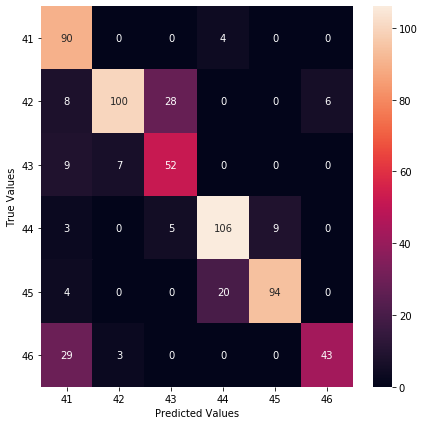

In [91]:
plot_cm(new_df['room_id'], y_pred_new)

In [30]:
# import shap
# shap.initjs()
# explainer = shap.TreeExplainer(rf_best_model)
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train, class_names=scans_df.room_id.unique())

### Create output folder and figures

In [143]:
date_time = datetime.now().strftime("%m%d%Y_%H%M%S")
path = date_time + '_output_folder'
os.mkdir(path) #new output folder in main dir

Number of WiFi scans per sample : 
count    8906.000000
mean       20.928812
std         7.236262
min         4.000000
25%        16.000000
50%        20.000000
75%        25.000000
max        56.000000
Name: n_scans, dtype: float64


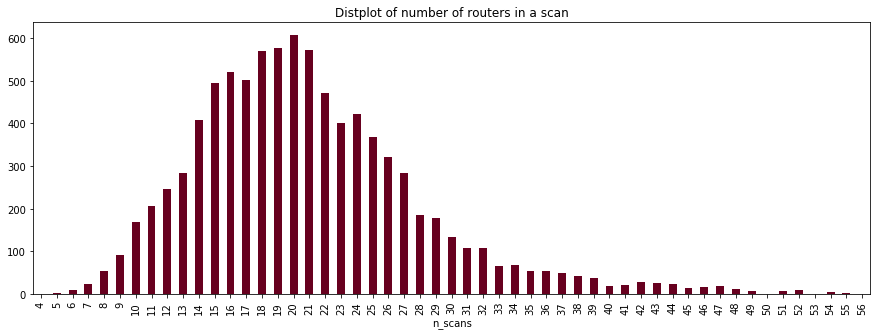

In [309]:
plt.figure(figsize=(15, 5))
#count only scans (not nan)
scans_df['n_scans'] = scans_df.apply(lambda x: x.count()-2, axis=1)  # (-2) for columns 'room_id' and 'imei' in scans_df

print('Number of WiFi scans per sample : ')
print(scans_df['n_scans'].describe())
scans_df.groupby('n_scans').size().plot(kind='bar', stacked=True, colormap='RdBu')#.bar(colo)
plt.title('Distplot of number of routers in a scan')
plt.savefig(path+"\\n_scans.jpg")

In [272]:
scans_df['apart'] = scans_df.room_id.apply(lambda x:str(x)[0])

In [279]:
new = pd.DataFrame(scans_df.groupby(['apart', 'imei']).size()).reset_index()

In [297]:
new['apart'].replace({'3':'apartment 1', '4':'apartment 2'})

0    apartment 1
1    apartment 1
2    apartment 1
3    apartment 1
4    apartment 1
5    apartment 2
6    apartment 2
7    apartment 2
8    apartment 2
9    apartment 2
Name: apart, dtype: object

Text(0.5, 1.0, 'Number of Samples per imei for each apartment')

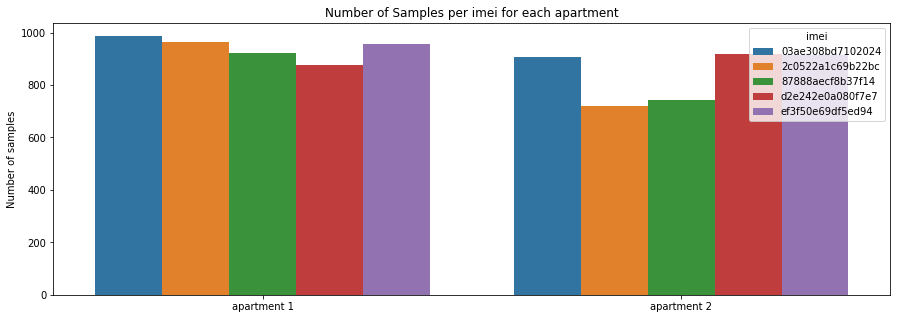

In [300]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=new['apart'].replace({'3':'apartment 1', '4':'apartment 2'}), y=new[0], hue=new['imei'])
ax.set(ylabel='Number of samples', xlabel='')
plt.title('Number of Samples per imei for each apartment')

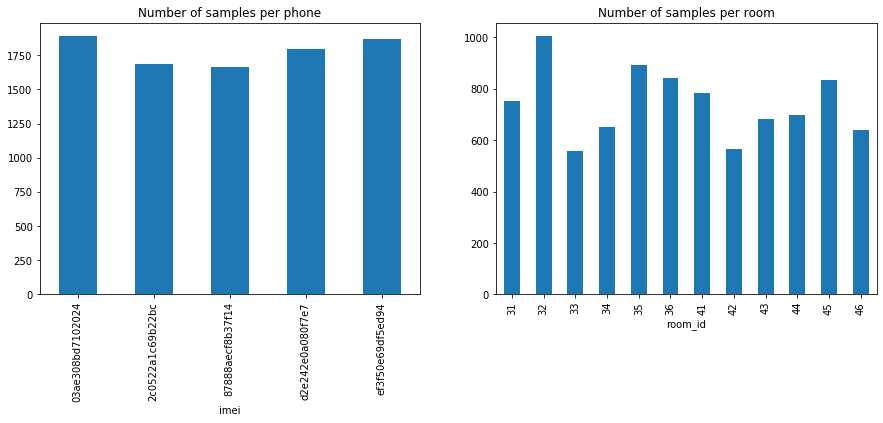

In [145]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title('Number of samples per phone')
scans_df.groupby('imei').size().plot.bar()
plt.subplot(1,2,2)
plt.title('Number of samples per room')
scans_df.groupby('room_id').size().plot.bar()
plt.savefig(path+"\\samples_per_phone_and_room.jpg")

In [146]:
plt.figure(figsize=(45, 45))
plt.subplots_adjust(wspace = 0.2 , hspace = 0.5)

i=1
for imei in imeis:
    plt.subplot(len(imeis),2,i)
    plt.title(f'Number of samples per room for phone {imei}')
    scans_df[scans_df['imei']==imei].groupby('room_id').size().plot.bar()
    plt.subplot(len(imeis),2,i+1)
    plt.title(f'Number of scnas per sample for phone {imei}')
    scans_df[scans_df['imei']==imei].groupby('n_scans').size().plot.bar()
    i+=2
plt.savefig(path+"\\scans_and_smaple_per_room_for_each_phone.jpg")